# Endogenous model shifts

In [184]:
using CSV;
using DataFrames;
using LinearAlgebra;
using Distributions;
include("../julia/utils.jl");

## Synthetic data

### Single run

#### Fitting the Bayesian classifier

In [185]:
include("../julia/bayes_logreg.jl");
include("../julia/optimization.jl");

In [186]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);

For plotting we will use the R package `ggplot2` which can be readily integrated into Julia (just like many other R packages, see for example [here](https://avt.im/blog/2018/03/23/R-packages-ggplot-in-julia#fn:rcall)).

In [187]:
using RCall
@rlibrary ggplot2
@rlibrary ggimage
@rlibrary emojifont
@rlibrary viridis
@rlibrary magick

In [188]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);

In [189]:
model = bayes_logreg(X,y);
w = model.μ;

In [190]:
step = 1;
expand = 20;
W = expandgrid((minimum(df.x1)-expand):step:(maximum(df.x1)+expand),(minimum(df.x2)-expand):step:(maximum(df.x2)+expand));
N_grid = size(W)[1];

In [191]:
y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
estimates = DataFrame(hcat(y_probit,W), :auto);
features = copy(df);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

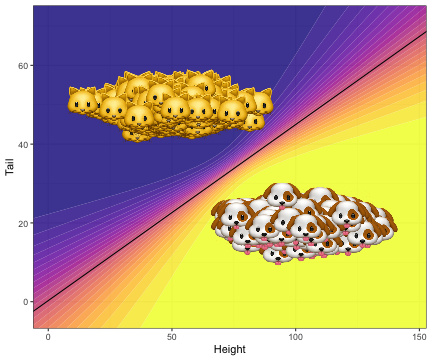

RObject{VecSxp}


In [192]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=1-w[1], slope=-w[2]/w[3]) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    theme_bw() # |>
    # p -> ggsave("www/predictive.png", plot = p, width=5, height=5)

#### Generating recourse

In [193]:
include("../julia/gradients.jl");
include("../julia/generate_recourse.jl");

In [194]:
recourse_generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=());
df_counterfactual = [copy(df) for i in 1:length(recourse_generators)];
for j in 1:length(recourse_generators)
    insertcols!(df_counterfactual[j], :type => String(keys(recourse_generators)[j]))
end

In [195]:
proportion = 0.2
using StatsBase
cats = findall(df.y.==0);
unhappy_cats = StatsBase.sample(cats,Int(round(proportion * length(cats))),replace=false);
X_f = [[df.x1[i], df.x2[i]] for i in unhappy_cats];

In [196]:
counterfactuals = DataFrame();
for i in unhappy_cats
    x_f = [df.x1[i], df.x2[i]]
    for j in 1:length(recourse_generators)
        recourse_name = keys(recourse_generators)[j]
        recourse = recourse_generators[j](x_f,gradient,model,1;generator_args[j]...)
        y_hat = predict(model, reshape(vcat(1,recourse.x_cf),(1,length(recourse.x_cf)+1)))[1]
        # Update large data frame:
        df_counterfactual[j].y[i] = y_hat
        df_counterfactual[j].x1[i] = recourse.x_cf[1]
        df_counterfactual[j].x2[i] = recourse.x_cf[2]
        # Append small data frame:
        cf = DataFrame(reshape(recourse.x_cf,(1,length(recourse.x_cf))),:auto)
        insertcols!(cf, :type => String(recourse_name))
        insertcols!(cf, :emoji=> ifelse(y_hat==1,"../www/dog.png","../www/cat.png"))
        counterfactuals = vcat(counterfactuals, cf)
    end
end

In [197]:
using Images, FileIO

In [198]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(intercept=(1-w[1])/w[3], slope=-w[2]/w[3]) +
    geom_image(
        data=features[setdiff(1:size(features)[1],unhappy_cats),:], 
        aes(x=:x1, y=:x2, image=:emoji), 
        size=0.1, 
        image_fun=R"function(img) magick::image_fx(img, expression = '0.5*a', channel = 'alpha')"
    ) +
    geom_image(data=counterfactuals, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/endogenouse_shifts.png", plot = p, width=8, height=4);

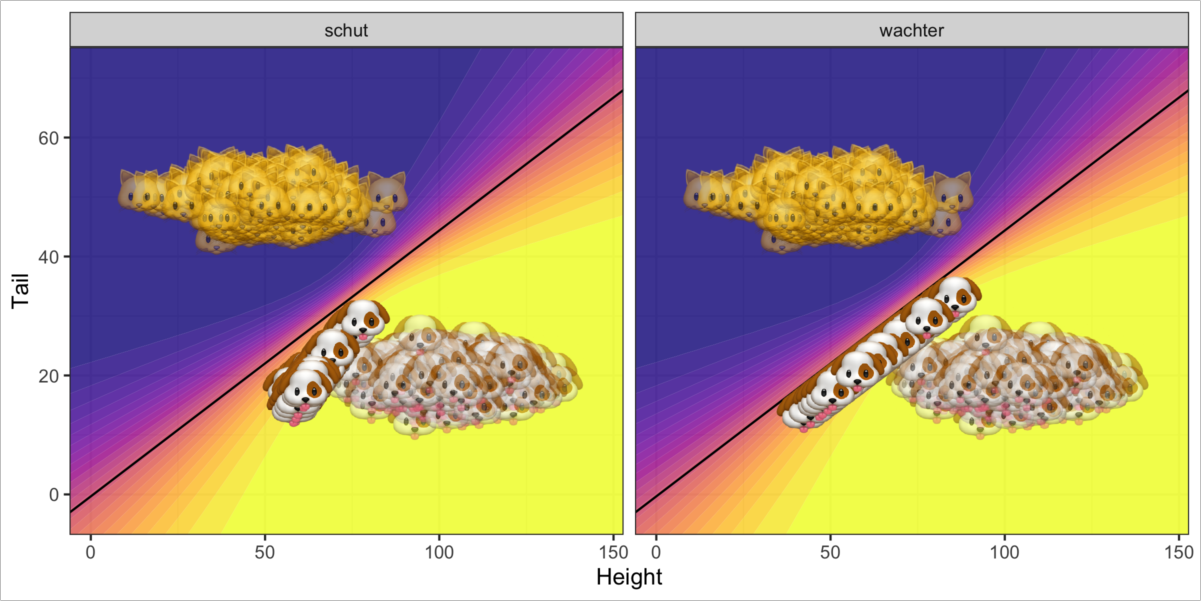

In [199]:
load("www/endogenouse_shifts.png")

#### Retraining classifier

In [200]:
estimates = DataFrame()
coefficients = DataFrame()
for j in 1:length(df_counterfactual)
    df_cf = df_counterfactual[j]
    recourse_name = String(keys(recourse_generators)[j])
    y = df_cf[:,:y];
    X = Matrix(df_cf[:,[:x1,:x2]]);
    X = [ones(N) X]; # add for constant
    model = bayes_logreg(X,y);
    coefficients_ = DataFrame(reshape(model.μ,(1,length(model.μ))), "w" .* string.(1:length(model.μ)))
    insertcols!(coefficients_, :const => 1-model.μ[1]/model.μ[3])
    insertcols!(coefficients_, :slope => -model.μ[2]/model.μ[3])
    insertcols!(coefficients_, :type => recourse_name)
    coefficients = vcat(coefficients,coefficients_);
    # Predictive posterior:
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    estimates_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(estimates_, :type => recourse_name)
    estimates = vcat(estimates, estimates_)
end

In [201]:
features = reduce(vcat, df_counterfactual);
transform!(features, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [202]:
ggplot() + 
    geom_contour_filled(data=estimates, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=coefficients, aes(intercept=:const, slope=:slope)) +
    geom_image(data=features, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~type") +
    theme_bw() |>
    p -> ggsave("www/post_shift.png", plot = p, width=8, height=4);

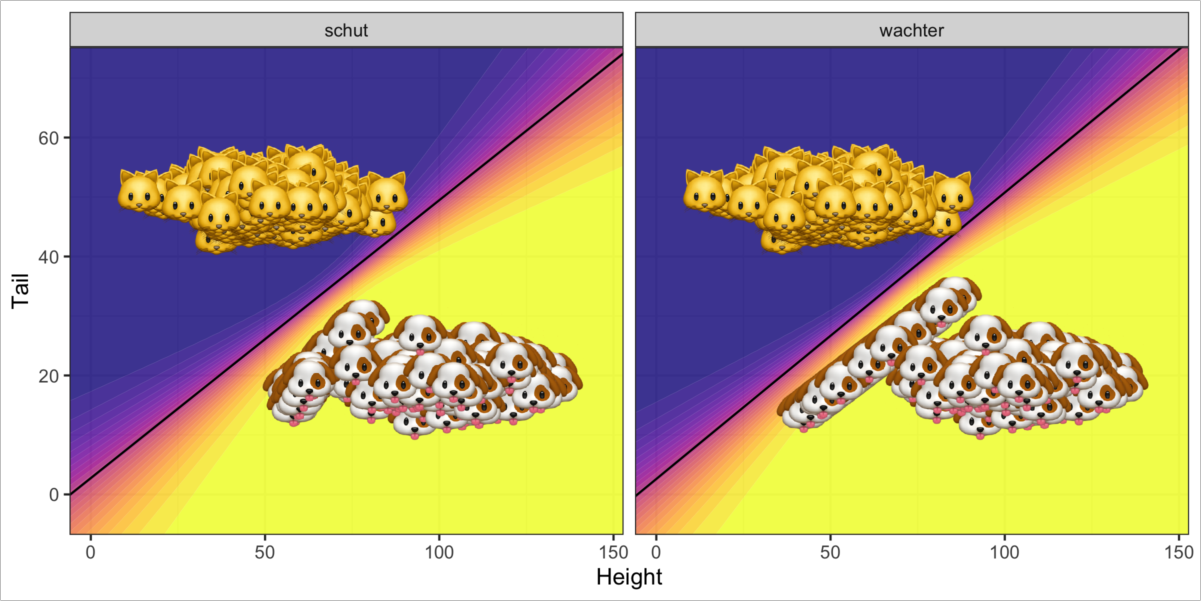

In [203]:
load("www/post_shift.png")

### Single run with holdout

The experimental setup in this section is adapted from Upadhyay et al. (2021):

1. Train classifier ($\mathcal{M}_1$) on 4 folds of data $\mathcal{D}$ (training data).
2. Provide recourse to 5th fold (holdout data).
3. Provide and implement recourse to $\mu$% of the training data. 
4. Retrain the classifier ($\mathcal{M}_2$) on training data with counterfactual labels.
5. Check validity of recourse provided in 2.

In [204]:
function experiment_holdout(X,y,target,generator,generator_args;proportion_training=0.5,proportion_holdout=1.0)
    # Setup:
    N = length(y);
    D = size(X)[2]; # number of features
    X_train, y_train, X_test, y_test = train_test_split(X,y;test_size=0.2);
    
    # 1. Train (M1):
    M1 = bayes_logreg(X_train,y_train);
    
    # 2. Recourse on training:
    examples = findall(y_train.!=target);
    eligible_examples = StatsBase.sample(examples,Int(round(proportion_training * length(examples))),replace=false);
    X_train_cf = copy(X_train)
    y_train_cf = copy(y_train)
    for i in eligible_examples
        x_f = X_train_cf[i,2:end]
        recourse = generator(x_f,gradient,M1,1;generator_args...)
        X_train_cf[i,2:end] = recourse.x_cf 
        y_train_cf[i] = recourse.y_cf
    end
    
    # 3. Retrain (M2):
    M2 = bayes_logreg(X_train_cf,y_train_cf);
    
    # 4. Recourse for holdout:
    examples = findall(y_test.==0);
    eligible_examples = StatsBase.sample(examples,Int(round(proportion_holdout * length(examples))),replace=false);
    X_test_cf = copy(X_test)
    y_test_cf = copy(y_test)
    avg_cost = 0
    pct_valid = 0
    N_eligible = length(eligible_examples)
    for i in eligible_examples
        # Implement recourse
        x_f = X_test_cf[i,2:end]
        recourse = generator(x_f,gradient,M1,1;generator_args...) # recourse against M1
        X_test_cf[i,2:end] = recourse.x_cf 
        y_test_cf[i] = predict(M2, vcat(1, recourse.x_cf); proba=false)[1] # label according to M2
        # Validity and cost
        avg_cost += recourse.cost/N_eligible
        pct_valid += valid(recourse; classifier=M2)/N_eligible
    end
    pct_valid = round(pct_valid; digits=5);
    
    return pct_valid, avg_cost
end;

In [205]:
target=1
generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.1,), schut=());
for i in 1:length(generators)
    experiment_holdout(X,y,target,generators[i],generator_args[i])
end

#### Train ($\mathcal{M}_1$)

In [206]:
df = CSV.read("../data/cats_dogs_large.csv", DataFrame);
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
X_train, y_train, X_test, y_test = train_test_split(X,y;test_size=0.2);

In [207]:
# Priors:
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);
# Train:
M1 = bayes_logreg(X_train,y_train);

#### Recourse for training sample

In [208]:
recourse_generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.1,), schut=());
proportion = 0.5
cats = findall(y_train.==0);
unhappy_cats = StatsBase.sample(cats,Int(round(proportion * length(cats))),replace=false);
X_train_cf = copy(X_train)
y_train_cf = copy(y_train)
# Apply recourse:
for i in unhappy_cats
    x_f = X_train_cf[i,2:end]
    recourse = recourse_generators[1](x_f,gradient,M1,1;generator_args[1]...)
    X_train_cf[i,2:end] = recourse.x_cf 
    y_train_cf[i] = recourse.y_cf
end

#### Retrain ($\mathcal{M}_2$)

In [209]:
M2 = bayes_logreg(X_train_cf,y_train_cf);

#### Provide recourse to holdout

In [210]:
unhappy_cats = findall(y_test.==0);
X_test_cf = copy(X_test)
y_test_cf = copy(y_test)
avg_cost = 0
pct_valid = 0
N_recourse = length(unhappy_cats)
for i in unhappy_cats
    # Implement recourse
    x_f = X_test_cf[i,2:end]
    recourse = recourse_generators[1](x_f,gradient,M1,1;generator_args[1]...) # recourse against M1
    X_test_cf[i,2:end] = recourse.x_cf 
    y_test_cf[i] = predict(M2, vcat(1, recourse.x_cf); proba=false)[1] # label according to M2
    # Validity and cost
    avg_cost += recourse.cost/N_recourse
    pct_valid += valid(recourse; classifier=M2)/N_recourse
end
pct_valid = round(pct_valid; digits=5);

### Dynamic

In [211]:
function recourse_retrain(X,y,classifier,target,recourse_generator,generator_args;gradient=gradient,proportion_recourse=0.2,n_rounds=10)
    # Setup:
    N = length(y);
    D = size(X)[2] # number of features
    w_0 = zeros(D+1) # zero-mean prior
    λ = 0.005
    H_0 = UniformScaling(λ)
    # Allocating memory:
    recourse_path = DataFrame()
    clf_path = []
    # Recursion:
    t = 1
    while t<=n_rounds
        # Train classifier:
        model = classifier(X,y) # might want to use w_t-1 as new prior
        clf_path = vcat(clf_path, model)
        w = model.μ
        # w_0 = w # posterior as new prior
        # H_0 = model.Σ
        # Provide recourse:
        undesired = findall(y.!=target)
        N_0 = length(undesired)
        recourse_eligible = StatsBase.sample(undesired,Int(round(proportion_recourse * N_0)),replace=false)
        for i in recourse_eligible
            x_f = X[i,:]
            recourse = recourse_generator(x_f,gradient,model,target;generator_args...)
            X[i,:] = recourse.x_cf
        end
        y = predict(model, [ones(N) X])
        recourse_outcome = DataFrame(hcat(y,X), vcat("y", "x" .* string.(1:D)))
        insertcols!(recourse_outcome, :period => t)
        recourse_path = vcat(recourse_path, recourse_outcome)
        # Updates:
        t += 1
    end
    return recourse_path, clf_path
end;

In [212]:
n_rounds=10;

#### Wachter et al.

In [213]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,recourse_generators[1],generator_args[1], n_rounds=n_rounds);

In [214]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [215]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_wachter.png", plot = p, width=8, height=2/(n_rounds/2)*8);

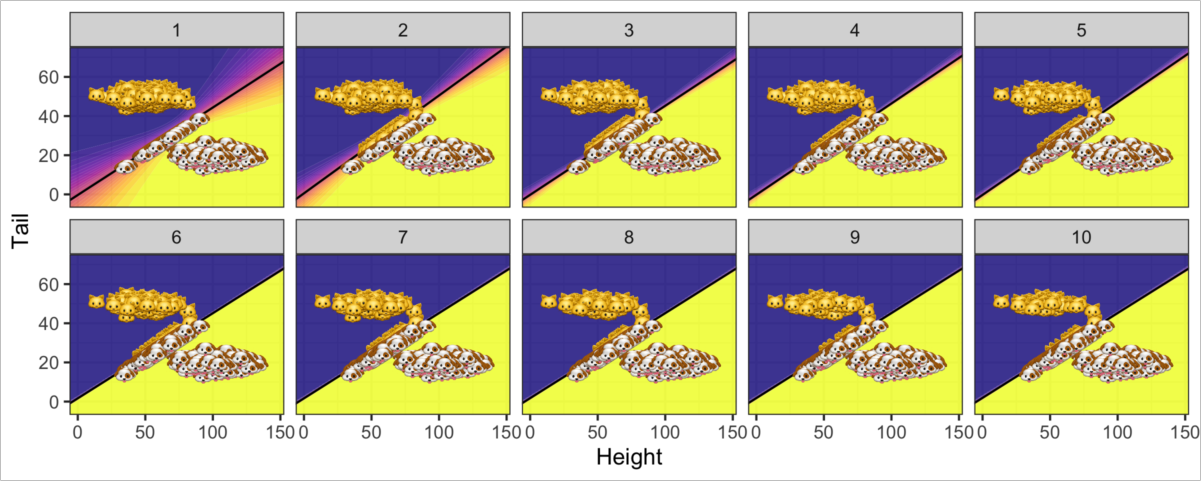

In [216]:
load("www/dynamic_wachter.png")

#### Schut et al.

In [217]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,recourse_generators[2],generator_args[2], n_rounds=n_rounds);

In [218]:
# Posterior predictive:
posterior_contour = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    y_probit = posterior_predictive(model, hcat(ones(N_grid), W));
    posterior_contour_ = DataFrame(hcat(y_probit,W), :auto);
    insertcols!(posterior_contour_, :period => i)
    posterior_contour = vcat(posterior_contour, posterior_contour_)
end

# Decision boundary:
decision_boundary = DataFrame()
for i in 1:length(clf_path)
    model = clf_path[i]
    decision_boundary_ = DataFrame(intercept=(1-model.μ[1])/model.μ[3], slope=-model.μ[2]/model.μ[3], period=i)
    decision_boundary = vcat(decision_boundary, decision_boundary_)
end

# Emoji
transform!(recourse_path, :y => (x -> ifelse.(x.==0,"../www/cat.png","../www/dog.png"))  => :emoji);

In [219]:
ggplot() + 
    geom_contour_filled(data=posterior_contour, aes(x = :x2, y = :x3, z = :x1), bins=25, alpha=0.8) +
    geom_abline(data=decision_boundary, aes(intercept=:intercept, slope=:slope)) +
    geom_image(data=recourse_path, aes(x=:x1, y=:x2, image=:emoji), size=0.1) +
    guides(fill="none") +
    scale_fill_viridis(option="C",discrete=true) +
    scale_x_continuous(expand = R"c(0, 0)") + scale_y_continuous(expand = R"c(0, 0)") +
    labs(x="Height", y="Tail") +
    facet_wrap(R".~period",ncol=round(n_rounds/2)) +
    theme_bw() |>
    p -> ggsave("www/dynamic_schut.png", plot = p, width=8, height=2/(n_rounds/2)*8);

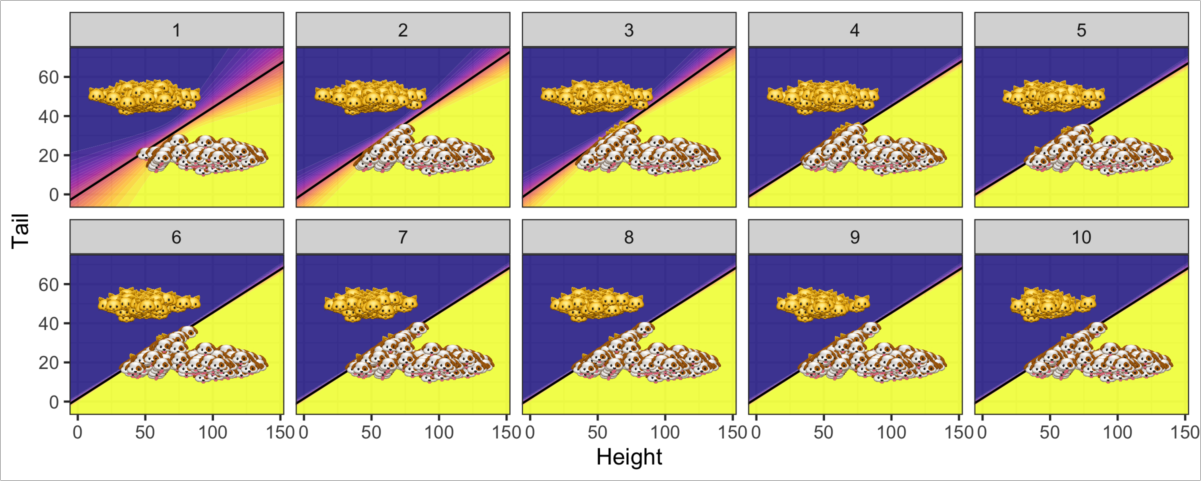

In [220]:
load("www/dynamic_schut.png")

## German credit data

In [221]:
df = CSV.read("../data/credit.csv", DataFrame);
df[!,:] = convert.(Float64, df[!,:]); # convert to floats

In [222]:
y = df[:,:y];
N = length(y);
X = Matrix(df[:,Not(:y)]);
X = [ones(N) X]; # add for constant
d = size(X)[2]; # number of features
w_0 = zeros(d); # zero-mean prior
λ = 0.005
H_0 = UniformScaling(λ);
model = bayes_logreg(X,y);
w = model.μ;

In [223]:
recourse_generators = (wachter = generate_recourse_wachter, schut = generate_recourse_schut);
generator_args = (wachter=(λ=0.01,), schut=(n=200,T=1000));

In [224]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,recourse_generators[1],generator_args[1], n_rounds=n_rounds);
sum(recourse_path[recourse_path.period.==1,:].y.==1)

939

In [225]:
y = df[:,:y];
X = Matrix(df[:,Not(:y)]);
recourse_path, clf_path = recourse_retrain(X,y,bayes_logreg,1,recourse_generators[2],generator_args[2], n_rounds=n_rounds);
sum(recourse_path[recourse_path.period.==1,:].y.==1)

939